<h1><center>🚸 GTSRB German Road Signs (Convolutional Neural Network) 🚸</center></h1>
<p><center><i>By Natan Szczepaniak</i></center></p>

<img width="400px" src="road_signs_header.jpeg"/>

Convolutional Neural Network.......

In [1]:
# Uncomment if missing dependencies
# !pip3 install wget tensorflow numpy matplotlib Pillow pandas tqdm

## Download, Preprocess and put image data into numpy arrays

The code below downloads the dataset from the ERDA website (if not downloaded already) and loads it into a neat format in a numpy array.

Unfortunately the images are not of uniform shape which would make it difficult to train our model on as it would mean irregular input parameters, this means we need to resize the images to 30x30x3 dimensions. Usually I would do this once, save the dataset and load it in later but I did this verbosely for demonstration purposes. :~)

The [source of the data](https://benchmark.ini.rub.de) provided a sample code to load in the data from their website however it was written in Python2 using outdated libraries so I redid it myself.

In [132]:
import os
import wget
import zipfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

from road_labels import label_name

# check TF version
print("TensorFlow Version: " + tf.__version__)

TensorFlow Version: 2.8.0


In [3]:
### LOAD IN THE DATASET (276MB) ###

# Image Constants & Dimensions
IMG_WIDTH = 30
IMG_HEIGHT = 30
CHANNELS = 3
CLASSES = 43

# Location of data
CUR_DIR = os.getcwd()
URL = "https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip"

In [98]:
# Function to load in data given a path
def load_roadsigns(path):
    '''Reads traffic sign data.

    Arguments: Path to traffic sign data
    Returns:   numpy array of images X and labels'''
    
    # Initialise the output arrays
    X = [] # images
    y = np.array([]) # labels
    
    print("Resizing images...")
    # Iterate through all the directories, pull out images and resize
    for i in range(CLASSES):
        
        # Messing around with paths of where the data is found
        class_label = f"{i:05}"
        class_folder = path+f"/{class_label}"
        datasheet = pd.read_csv(class_folder+f"/GT-{class_label}.csv",delimiter=";")

        image_files = list(datasheet["Filename"])
        labels = list(datasheet["ClassId"].astype(int))
        
        y = np.append(y,labels)
        
        for image_file in tqdm(image_files):
            try: 
                image = Image.open(class_folder+"/"+image_file) 
                image = image.resize((IMG_WIDTH,IMG_HEIGHT)) 
                image = np.array(image)
                X.append(image)
            except Exception as e: 
                print(e) 
                
    # Converting to numpy arrays
    # It was actually quicker to do the appending in native lists and converting lol ¯\_(ツ)_/¯
    X = np.array(X)
    y = y.astype(int)
                
    return X, y

In [66]:
# Check if file already downloaded
if not os.path.isfile("GTSRB_Final_Training_Images.zip"):
    if not os.path.isdir("GTSRB"):
        print("Downloading Dataset...")
        wget.download(URL,".")
        print("Downloaded!")
        
        # Unzip the file into a folder
        with zipfile.ZipFile("GTSRB_Final_Training_Images.zip","r") as zip_ref:
            zip_ref.extractall(".")
        
        os.remove("GTSRB_Final_Training_Images.zip")
    else:
        print("Dataset already downloaded.")
else:
    print("Dataset already downloaded.")
    
# Load in dataset into memory
X, y = load_roadsigns("GTSRB/Final_Training/Images")

Dataset already downloaded.
Resizing images...


100%|███████████████████████████████████████| 240/240 [00:00<00:00, 1905.81it/s]


# Data Exploration
Now that the dataset is downloaded and reshaped to 30x30x3 dimensions we can look at what the images actually look like and the labels that are available to us.

I have created a seperate python module which holds the corresponding names for label numbers. This is in a form of a simple dictionary which can be referenced for ease of use and to reduce bloated code in this notebook.

In [67]:
print(f"Dimensions of images array: {X.shape}")
print(f"Dimensions of labels array: {y.shape}")

Dimensions of images array: (39209, 30, 30, 3)
Dimensions of labels array: (39209,)


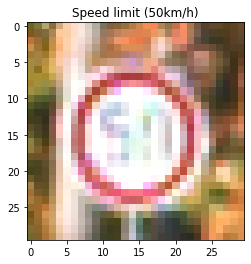

In [130]:
# Here we can visualise our images and their corresponding labels
def plot_sign(X,y,n):
    plt.imshow(X[n])
    plt.title(label_name[y[n]])

# Change index to see image and associated label
plot_sign(X,y,3000)

<AxesSubplot:title={'center':'Class Distribution of Images'}, xlabel='label'>

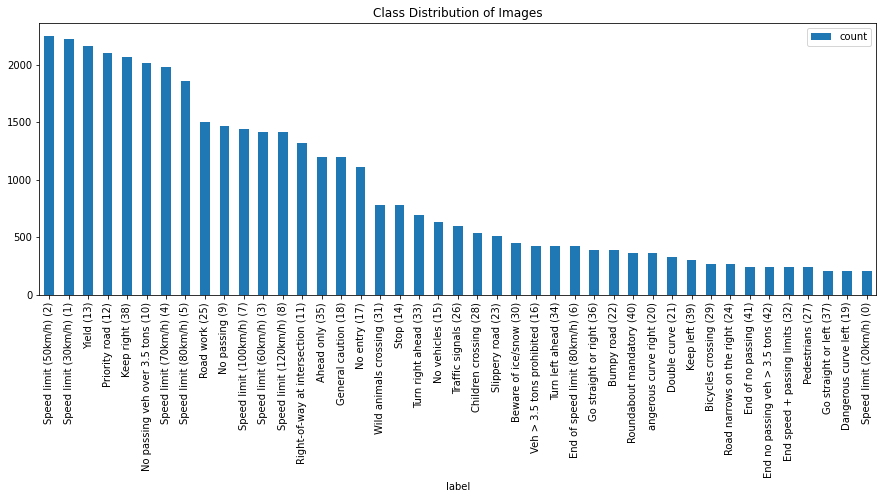

In [131]:
def format_label(label):
    return label_name[label]+f" ({label})"

# Plotting the distribution of the data
dist = pd.DataFrame({"label":np.unique(y),"count":np.bincount(y)})
dist["label"] = dist["label"].apply(format_label)
dist = dist.sort_values("count",ascending=False)

dist.plot(kind="bar",x="label",y="count",figsize=(15,5),title="Class Distribution of Images")

We can clearly see by this that this dataset is extremely skewed. This would make any model we make into being biased or perform better on some classes. To address this we can create more data by rotating, transforming and resizing the images.

# Data Augmentation

Biggest issue with this dataset is the skewedness of the images available for each class. If taken to training, this would lead to some classes being predicted with higher accuracy than others. The model could also be skewed towards these samples.

To combat this we can generate some more data by rotating, shifting, shearing and zooming. For this example I have chosen

In [135]:
datagen = ImageDataGenerator(
    rotation_range=35, # Rotate randomly from 0 to 45 (not too far)
    height_shift_range=0.25,
    width_shift_range=0.25,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode="reflect"
)

In [134]:
help(datagen)

Help on ImageDataGenerator in module keras.preprocessing.image object:

class ImageDataGenerator(keras_preprocessing.image.image_data_generator.ImageDataGenerator)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |   The data will be looped over (in batches).
 |  
 |  Args:
 |      featurewise_center: Boolean.
 |          Set input mean to 0 over the dataset, feature-wise.
 |      samplewise_center: Boolean. Set each sample mean to 0.
 |      featurewise_